
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Alice Breton, étudiante à la maîtrise en génie informatique. Elle a suivi le cours lors de la session Hiver 2019.



# Projet : Débordement d'égouts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

Dans un premier temps, vous devrez récupérer l'archive *data.zip* sur Moodle. Ce dossier contient les fichiers suivants :
- surverses.csv
- precipitation.csv
- ouvrages-surverses.csv
- test.csv

Veuillez le décompresser dans le répertoire de ce calepin.

Le fichier *surverse.csv* répertorie s'il y a surverse (1) ou non (0) au cours de la journée pour les 170 ouvrages de débordement de 2013 à 2018 pour les mois de mai à octobre (inclusivement). Des renseignements additionnels sur les données sont disponibles à l'adresse suivante :

http://donnees.ville.montreal.qc.ca/dataset/debordement


Le fichier *precipitation.csv* contient les précipitations horaires en dixième de *mm* enregistrées à 5 stations pluviométriques de 2013 à 2019 :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Plus d'informations sur les précipitations sont disponibles à l'adresse suivante :

https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019

Le fichier *ouvrages-surverses.csv* contient différentes caractéristiques des ouvrages de débordement. 

http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse

Le fichier *test.csv* contient les ouvrages et les jours pour lesquels vous devez prédire s'il y a eu surverse (true) ou non (false). Notez que l'on s'intéresse ici à 5 ouvrages de débordement localisés tout autour de l'Ile de Montréal :
- 3260-01D dans Rivière-des-Prairies 
- 3350-07D dans Ahunstic 
- 4240-01D dans Pointe-aux-Trembles 
- 4350-01D dans le Vieux-Montréal 
- 4380-01D dans Verdun

#### Remarque

Dans le projet, on ne s'intéresse qu'aux surverses occasionnées par les précipitations. On ignore les surverses occasionnées par 
- fonte de neige (F)
- travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque Nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

In [1]:
using Printf

In [2]:
using CSV, DataFrames, Statistics, Dates, Gadfly

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/macbookpro/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


# Chargement des données et nettoyage préliminaire

## Chargement des surverses

In [3]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = compacttype(::Type, ::Int64) at show.jl:39
└ @ DataFrames /Users/macbookpro/.julia/packages/DataFrames/XuYBH/src/abstractdataframe/show.jl:39


## Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [4]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [5]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String
1,0642-01D,2013-05-01,0,Inconnue
2,0642-01D,2013-05-02,0,Inconnue
3,0642-01D,2013-05-03,0,Inconnue
4,0642-01D,2013-05-04,0,Inconnue
5,0642-01D,2013-05-05,0,Inconnue


#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [6]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64⍰
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


#### Exclusion des lignes où :SURVERSE est manquante

In [7]:
surverse_df = dropmissing(data, disallowmissing=true)
first(surverse_df,5)
print(size(surverse_df))

(161098, 3)

##### Point important à noter pour la suite: les cas négatifs sont beaucoup plus présents que les cas positifs.

In [48]:
# Proportion de positifs : 
positifs = filter(row -> row.SURVERSE == 1, surverse_df)
size_p = size(positifs, 1)

# Proportion de négatifs :
negatifs = filter(row -> row.SURVERSE == 0, surverse_df)
size_n = size(negatifs, 1)

p_positifs = size_p/size(surverse_df, 1)
p_negatifs = size_n/size(surverse_df, 1)

print("Il y a $size_p cas positifs et $size_n cas négatifs \n")
print("La proportion de posistifs est de : $p_positifs \n")
print("La proportion de négatifs est de: $p_negatifs")

Il y a 5636 cas positifs et 155462 cas négatifs 
La proportion de posistifs est de : 0.03498491601385492 
La proportion de négatifs est de: 0.9650150839861451

In [ ]:
# 4350-01D dans le Vieux-Montréal
# 3260-01D dans Rivière-des-Prairies
# 4240-01D dans Pointe-aux-Trembles
# 3350-07D dans Ahunstic
# 4380-01D dans Verdun
# ouvrages = filter(row -> row.NO_OUVRAGE ∈ ["4350-01D","3260-01D","4240-01D", ], surverse_df)
print("positifs : $size_p , negatifs : $size_n")
#map(cols => f, gd::GroupedDataFrame)
#map(positifs[:, :DATE] => (x -> Dates.Month(x).value), positifs)

size(filter(row -> row.DATE == Date(Dates.Year(2019),Dates.Month(5),Dates.Day(2)), positifs), 1)
#e = map( x -> Dates.Month(x).value , (positifs[!, :DATE]))
#positifs[!, :DATE] = e


#replace.(positifs[:, :DATE], date => Dates.Month(date))
# by(positifs, :DATE,  Mai = :McTavish=>sum, Juin = :Bellevue=>sum, 
#    Juillet = :Assomption=>sum, Aout = :Trudeau=>sum, Septembre = :StHubert=>sum, Octobre =)
# first(pcp_sum ,5)
# positifs
#plot(positifs, x=:DATE, Geom.bar)
# positifs = groupby(positifs, :DATE)
# counter(positifs[:DATE])
# by(positifs, :DATE, funcadd -> sum(funcadd[:counts]))
# print(positifs)

#ouvrage="4350-01D"
#a = filter(row -> row.NO_OUVRAGE == ouvrage, positifs)
#a

In [9]:
size(filter(row -> row.DATE == Date(Dates.Year(2019),Dates.Month(5),Dates.Day(2)), positifs), 1)

0

## Chargement des précipitations

In [10]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


## Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

In [11]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,missing
2,2013-05-01,1,0,0,0,0,missing
3,2013-05-01,2,0,0,0,0,missing
4,2013-05-01,3,0,0,0,0,missing
5,2013-05-01,4,0,0,0,0,missing


# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

In [56]:
pcp_sum = by(data, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)
first(pcp_sum ,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,missing
2,2013-05-02,0,0,0,0,missing
3,2013-05-03,0,0,0,0,missing
4,2013-05-04,0,0,0,0,missing
5,2013-05-05,0,0,0,0,missing


#### Extraction du taux horaire journalier maximum des précipitations pour chacune des stations météorologiques

In [55]:
pcp_max = by(data, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,missing
2,2013-05-02,0,0,0,0,missing
3,2013-05-03,0,0,0,0,missing
4,2013-05-04,0,0,0,0,missing
5,2013-05-05,0,0,0,0,missing


#### Beaucoup de missing sont présents pour chaque colonne :

In [58]:
missings_pcp_sum = [sum(ismissing.(col)) for col in eachcol(pcp_sum)]

missings_pcp_max = [sum(ismissing.(col)) for col in eachcol(pcp_max)]

print(missings_pcp_sum)

print(missings_pcp_max)

[0, 100, 190, 107, 37, 234][0, 100, 190, 107, 37, 234]

On va essayer de remédier à celà : Si une ligne contient une colonne missing,
on va la remplacer par la moyenne de toutes les autres colonnes qui ne sont pas missing.

In [14]:
# si row contient une valeur missing, la fonction remplace missing
# par la moyenne des autres valeurs qui ne sont pas missing
function average_on_missing(row::DataFrameRow)

    row_size = size(row, 1)
    new_row = m = Array{Float64}(undef, row_size)
    count_missing = 0
    missing_indexes = zeros(Int8, row_size)
    
    for i = 1:row_size
         if row[i] === missing 
             count_missing += 1
             missing_indexes[i] = 1
         end
     end
     
    if count_missing != 0 && count_missing != row_size
         mean = 0
         for i = 1:row_size
             if missing_indexes[i] == 0
                 mean += row[i]
             end
         end
         mean = mean / (row_size - count_missing)
         for i = 1:row_size
             if missing_indexes[i] == 1
                 row[i] = floor(Int64, mean)
             end
         end
    end
end

average_on_missing (generic function with 1 method)

In [61]:
for row in eachrow(pcp_sum)
    average_on_missing(row[2:end])
end
for row in eachrow(pcp_max)
    average_on_missing(row[2:end])
end

Nous réduisons donc considérablement les valeurs missings en faisant la supposition que les valeurs missing ne devraient pas trop être eloignées de la moyenne pour chaque ligne.

In [62]:
missings_pcp_sum = [sum(ismissing.(col)) for col in eachcol(pcp_sum)]

missings_pcp_max = [sum(ismissing.(col)) for col in eachcol(pcp_max)]

print(missings_pcp_sum)

print(missings_pcp_max)

[0, 3, 3, 3, 3, 3][0, 3, 3, 3, 3, 3]

# Construction des variables explicatives pour chaque ouvrage à prédire

Pour les 5 ouvrages demandés, on les a localisé sur une carte. Ensuite nous avons pris les stations pluviométrique les plus proches
pour ensuite faire une moyenne.
Donc pour chaque ouvrage, nous avons : 
<ul>
    <li> x₁ correspond à la moyenne des sommes journalières des précipitations des stations pluviométriques les plus proches. 
    </li>
    <li> x₂ correspond à la moyenne des taux horaires maximum journaliers des précipitations des stations pluviométriques les plus proches. 
    </li>
    <li> x₃ correspond à la moyenne des taux horaires maximum journaliers des 5 stations pluviométriques.
    </li>
</ul>
   



In [60]:
# 4350-01D dans le Vieux-Montréal
# 3260-01D dans Rivière-des-Prairies
# 4240-01D dans Pointe-aux-Trembles
# 3350-07D dans Ahunstic
# 4380-01D dans Verdun

moyennes = []
variances = []


# Vieux port de Montréal.
ouvrage = "4350-01D"
df = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)
x₁ = Array{Union{Missing, Int64}}(missing, size(df,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(df,1)) # variable pour le max journalier
x₃ = Array{Union{Missing, Float32}}(missing, size(df,1)) # variable pour le nombre de surverses le même jour

for i=1:size(df,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    ind = findfirst(pcp_max[:,:date] .== df[i,:DATE])
    
    x₂[i] = pcp_max[ind,:McTavish]
    
    x₃[i] = (pcp_max[ind,:McTavish] + pcp_max[ind,:StHubert] + pcp_max[ind,:Assomption] 
                + pcp_max[ind,:Trudeau] + pcp_max[ind,:Bellevue] ) / 5
    
end

df[!,:SUM] = x₁
df[!,:MAX] = x₂
df[!,:MOYENNE] = x₃



dropmissing!(df, [:SUM, :MAX, :MOYENNE],disallowmissing=true)

μ = ( mean(df[!, 4]), mean(df[!, 5]), mean(df[!, 6]) )
σ = ( std(df[!, 4]), std(df[!, 5]), std(df[!, 6]) )
push!(variances, σ)
push!(moyennes, μ)

for i=4:6
    df[!, i] = (df[!, i] .- mean(df[!, i]))./std(df[!, i])
end

########


#############

#Rivière-des-Prairies
#cette ouvrage ne se situe pas près d'une station pluviométrique en particulier
#On prend donc la moyenne des 3 stations les plus proches.
ouvrage = "3260-01D"
df1 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)
x₁ = Array{Union{Missing, Float32}}(missing, size(df1,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Float32}}(missing, size(df1,1)) # variable pour le max journalier
x₃ = Array{Union{Missing, Float32}}(missing, size(df1,1)) # variable pour le nombre de surverses le même jour

for i = 1:size(df1,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df1[i,:DATE])

    x₁[i] = ((pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert]  + pcp_sum[ind, :Assomption])/ 3)
    
    ind = findfirst(pcp_max[:,:date] .== df1[i,:DATE])
    
    x₂[i] = ((pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] ) / 3)
    
    x₃[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
                pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
    
end

df1[!,:SUM] = x₁
df1[!,:MAX] = x₂
df1[!,:MOYENNE] = x₃

dropmissing!(df1, [:SUM, :MAX, :MOYENNE],disallowmissing=true)

μ = ( mean(df1[!, 4]), mean(df1[!, 5]), mean(df1[!, 6]) )
σ = ( std(df1[!, 4]), std(df1[!, 5]), std(df1[!, 6]) )
push!(variances, σ)
push!(moyennes, μ)

for i=4:6
    df1[!, i] = (df1[!, i] .- mean(df1[!, i]))./std(df1[!, i])
end


# Pointe aux trembles:
# Pareil que pour rivières des prairies
ouvrage = "4240-01D"
df2 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)
x₁ = Array{Union{Missing, Float32}}(missing, size(df2,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Float32}}(missing, size(df2,1)) # variable pour le max journalier
x₃ = Array{Union{Missing, Float32}}(missing, size(df2,1)) # variable pour le nombre de surverses le même jour


for i=1:size(df2,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df2[i,:DATE])
    
    x₁[i] = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert] + pcp_sum[ind, :Assomption])/3
    
    ind = findfirst(pcp_max[:,:date] .== df2[i,:DATE])
    
    x₂[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption])/3
    
    x₃[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue]) / 5
    
end

df2[!,:SUM] = x₁
df2[!,:MAX] = x₂
df2[!,:MOYENNE] = x₃

dropmissing!(df2, [:SUM, :MAX, :MOYENNE],disallowmissing=true)

μ = ( mean(df2[!, 4]), mean(df2[!, 5]), mean(df2[!, 6]) )
σ = ( std(df2[!, 4]), std(df2[!, 5]), std(df2[!, 6]) )
push!(variances, σ)
push!(moyennes, μ)

for i=4:6
    df2[!, i] = (df2[!, i] .- mean(df2[!, i]))./std(df2[!, i])
end

# Ahunstic
ouvrage = "3350-07D"
df3 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)
x₁ = Array{Union{Missing, Float32}}(missing, size(df3,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Float32}}(missing, size(df3,1)) # variable pour le max journalier
x₃ = Array{Union{Missing, Float32}}(missing, size(df3,1)) # variable pour le nombre de surverses le même jour


for i=1:size(df3,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df3[i,:DATE])
    
    x₁[i] = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :Trudeau])/2
    
    ind = findfirst(pcp_max[:,:date] .== df3[i,:DATE])
    
    x₂[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :Trudeau])/2
    
    x₃[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
    
end

df3[!,:SUM] = x₁
df3[!,:MAX] = x₂
df3[!,:MOYENNE] = x₃

dropmissing!(df3, [:SUM, :MAX, :MOYENNE],disallowmissing=true)
σ = ( std(df3[!, 4]), std(df3[!, 5]), std(df3[!, 6]) )
push!(variances, σ)
μ = ( mean(df3[!, 4]), mean(df3[!, 5]), mean(df3[!, 6]) )
push!(moyennes, μ)

for i=4:6
    df3[!, i] = (df3[!, i] .- mean(df3[!, i]))./std(df3[!, i])
end

# Verdun
ouvrage = "4380-01D"
df4 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)
x₁ = Array{Union{Missing, Float32}}(missing, size(df4,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Float32}}(missing, size(df4,1)) # variable pour le max journalier
x₃ = Array{Union{Missing, Float32}}(missing, size(df4,1)) # variable pour le nombre de surverses le même jour


for i=1:size(df,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df4[i,:DATE])
    
    x₁[i] = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert])/2
    
    ind = findfirst(pcp_max[:,:date] .== df4[i,:DATE])
    
    x₂[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert])/2
    
    x₃[i] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
    
end

df4[!,:SUM] = x₁
df4[!,:MAX] = x₂
df4[!,:MOYENNE] = x₃

dropmissing!(df4, [:SUM, :MAX, :MOYENNE],disallowmissing=true)
σ = ( std(df4[!, 4]), std(df4[!, 5]), std(df4[!, 6]) )
push!(variances, σ)
μ = ( mean(df4[!, 4]), mean(df4[!, 5]), mean(df4[!, 6]) )
push!(moyennes, μ)

# using StatsBase
# dt = fit(ZScoreTransform, df4[!,4]')
# print(StatsBase.transform(dt, df4[!, 4]'))

for i=4:6
    df4[!, i] = (df4[!, i] .- mean(df4[!, i]))./std(df4[!, i])
end

#first(df4,10)
#first(df,10)
# mean(df4[!, 4])
# std(df4[!, 4])
#using StatsBase
#dt = fit(ZScoreTransform, df4[!,4]')
#StatsBase.transform(dt', df4[!, 4])
#first(df4, 100)

#### Construction d'un modèle pour chaque ouvrage

In [76]:
?std

search: std stdm stdin stdout stderr stderror lastdayofyear lastdayofweek



```
std(itr; corrected::Bool=true, mean=nothing[, dims])
```

Compute the sample standard deviation of collection `itr`.

The algorithm returns an estimator of the generative distribution's standard deviation under the assumption that each entry of `itr` is an IID drawn from that generative distribution. For arrays, this computation is equivalent to calculating `sqrt(sum((itr .- mean(itr)).^2) / (length(itr) - 1))`. If `corrected` is `true`, then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` with `n` the number of elements in `itr`.

A pre-computed `mean` may be provided.

If `itr` is an `AbstractArray`, `dims` can be provided to compute the standard deviation over dimensions, and `means` may contain means for each dimension of `itr`.

!!! note
    If array contains `NaN` or [`missing`](@ref) values, the result is also `NaN` or `missing` (`missing` takes precedence if array contains both). Use the [`skipmissing`](@ref) function to omit `missing` entries and compute the standard deviation of non-missing values.


---

```
std(x::AbstractArray, w::AbstractWeights, [dim]; mean=nothing, corrected=false)
```

Compute the standard deviation of a real-valued array `x`, optionally over a dimension `dim`. Observations in `x` are weighted using weight vector `w`. The uncorrected (when `corrected=false`) sample standard deviation is defined as:

$$
\sqrt{\frac{1}{\sum{w}} \sum_{i=1}^n {w_i\left({x_i - μ}\right)^2 }}
$$

where $n$ is the length of the input and $μ$ is the mean. The unbiased estimate (when `corrected=true`) of the population standard deviation is computed by replacing $\frac{1}{\sum{w}}$ with a factor dependent on the type of weights used:

  * `AnalyticWeights`: $\frac{1}{\sum w - \sum {w^2} / \sum w}$
  * `FrequencyWeights`: $\frac{1}{\sum{w} - 1}$
  * `ProbabilityWeights`: $\frac{n}{(n - 1) \sum w}$ where $n$ equals `count(!iszero, w)`
  * `Weights`: `ArgumentError` (bias correction not supported)

---

```
std(d::UnivariateDistribution)
```

Return the standard deviation of distribution `d`, i.e. `sqrt(var(d))`.


In [75]:
using RDatasets, LIBSVM

# On va apprendre à séparer les jours où il y a eu surverse des autres jours.
# surverse_df
weight_factor = 0.31

# SVM format expects observations in columns and features in rows
X = convert(Matrix, df[!, 4:end])'
p, n = size(X)
Y = df[!, :SURVERSE]
labels = convert(Vector, Y)
model = svmtrain(X, labels; degree=5, kernel=Kernel.Polynomial, weights=Dict([(0, weight_factor), (1, 1.0)]));

X₁ = convert(Matrix, df1[!, 4:end])'
p₁, n₁ = size(X₁)
Y₁ = df1[!, :SURVERSE]
labels₁ = convert(Vector, Y₁)
model₁ = svmtrain(X₁, labels₁;  kernel=Kernel.Polynomial, degree=5, weights=Dict([(0, weight_factor), (1, 1.0)]));

X₂  = convert(Matrix, df2[!, 4:end])'
p₂, n₂ = size(X₂)
Y₂ = df2[!, :SURVERSE]
labels₂ = convert(Vector, Y₂)
model₂ = svmtrain(X₂, labels₂; degree=5, kernel=Kernel.Polynomial, weights=Dict([(0, weight_factor), (1, 1.0)]));

X₃ = convert(Matrix, df3[!, 4:end])'
p₃, n₃ = size(X₃)
Y₃ = df3[!, :SURVERSE]
labels₃ = convert(Vector, Y₃)
model₃ = svmtrain(X₃, labels₃; degree=5, kernel=Kernel.Polynomial, weights=Dict([(0, weight_factor), (1, 1.0)]));

X₄ = convert(Matrix, df4[!, 4:end])'
p₄, n₄ = size(X₄)
Y₄ = df4[!, :SURVERSE]
labels₄ = convert(Vector, Y₄)
model₄ = svmtrain(X₄, labels₄; degree=5, kernel=Kernel.Polynomial, weights=Dict([(0, weight_factor), (1, 1.0)]));

# SVM format expects positive and negative examples to +1/-1
# Y = [surverse == 1 ? 1.0 : -1.0 for entry in df[:SURVERSE]]
#Y = df[!, :SURVERSE]
#labels = convert(Vector, Y)


# # Select a subset of the data for training, test on the rest.
# train = randbool(n)
# # We'll fit a model with all of the default parameters
# model = svm(X[:,train], Y[train])

#model₃ = svmtrain(X₃, labels₃);

# (predicted_label, decision_value) = svmpredict(model, X);
# print(predicted_label)

# print(predicted_labels)
# m =mean((predicted_labels .== labels[2:2:end]))*100

# Compute accuracy
#print("Accuracy: %.2f%%\n", )

# And now evaluate that model on the testset
#accuracy = countnz(predict(model, X[:,~train]) .== Y[~train])/countnz(~train)
#print(predicted_labels)

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que la somme des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly /Users/macbookpro/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


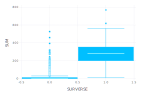

In [17]:
plot(df, x=:SURVERSE, y=:SUM, Geom.boxplot)



#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que le maximum journalier des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

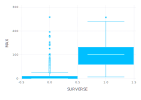

In [18]:
plot(df, x=:SURVERSE, y=:MAX, Geom.boxplot)

# Création du fichier de prédictions pour soumettre sur Kaggle

In [19]:
?svmtrain

search: svmtrain



```julia
svmtrain{T, U<:Real}(X::AbstractMatrix{U}, y::AbstractVector{T}=[];
    svmtype::Type=SVC, kernel::Kernel.KERNEL=Kernel.RadialBasis, degree::Integer=3,
    gamma::Float64=1.0/size(X, 1), coef0::Float64=0.0,
    cost::Float64=1.0, nu::Float64=0.5, epsilon::Float64=0.1,
    tolerance::Float64=0.001, shrinking::Bool=true,
    probability::Bool=false, weights::Union{Dict{T, Float64}, Compat.Nothing}=nothing,
    cachesize::Float64=200.0, verbose::Bool=false)
```

Train Support Vector Machine using LIBSVM using response vector `y` and training data `X`. The shape of `X` needs to be (nfeatures, nsamples). For one-class SVM use only `X`.

# Arguments

  * `svmtype::Type=LIBSVM.SVC`: Type of SVM to train `SVC` (for C-SVM), `NuSVC`   `OneClassSVM`, `EpsilonSVR` or `NuSVR`. Defaults to `OneClassSVM` if   `y` is not used.
  * `kernel::Kernels.KERNEL=Kernel.RadialBasis`: Model kernel `Linear`, `polynomial`,   `RadialBasis`, `Sigmoid` or `Precomputed`.
  * `degree::Integer=3`: Kernel degree. Used for polynomial kernel
  * `gamma::Float64=1.0/size(X, 1)` : γ for kernels
  * `coef0::Float64=0.0`: parameter for sigmoid and polynomial kernel
  * `cost::Float64=1.0`: cost parameter C of C-SVC, epsilon-SVR, and nu-SVR
  * `nu::Float64=0.5`: parameter nu of nu-SVC, one-class SVM, and nu-SVR
  * `epsilon::Float64=0.1`: epsilon in loss function of epsilon-SVR
  * `tolerance::Float64=0.001`: tolerance of termination criterion
  * `shrinking::Bool=true`: whether to use the shrinking heuristics
  * `probability::Bool=false`: whether to train a SVC or SVR model for probability estimates
  * `weights::Union{Dict{T, Float64}, Compat.Nothing}=nothing`: dictionary of class weights
  * `cachesize::Float64=100.0`: cache memory size in MB
  * `verbose::Bool=false`: print training output from LIBSVM if true
  * `nt::Integer=0`: number of OpenMP cores to use, if 0 it is set to OMP*NUM*THREADS, if negative it is set to the max number of threads

Consult LIBSVM documentation for advice on the choise of correct parameters and model tuning.


In [66]:
# Chargement du fichier de test
test = CSV.read("data/test.csv")

# 4350-01D dans le Vieux-Montréal
# 3260-01D dans Rivière-des-Prairies
# 4240-01D dans Pointe-aux-Trembles
# 3350-07D dans Ahunstic
# 4380-01D dans Verdun

predictions = DataFrame(Date=Date[], SUM=Int64[], MAX=Int64[], MOYENNE=Float32[])
predictions₁ = DataFrame(Date=Date[], SUM=Float32[], MAX=Float32[], MOYENNE=Float32[])
predictions₂ = DataFrame(Date=Date[], SUM=Float32[], MAX=Float32[], MOYENNE=Float32[])
predictions₃ = DataFrame(Date=Date[], SUM=Float32[], MAX=Float32[], MOYENNE=Float32[])
predictions₄ = DataFrame(Date=Date[], SUM=Float32[], MAX=Float32[], MOYENNE=Float32[])

predictions_array = [predictions, predictions₁, predictions₂, predictions₃, predictions₄]

for row in eachrow(test)
    if row[:NO_OUVRAGE] == "4350-01D"
        inds = findfirst(pcp_sum[:,:date] .== row[:DATE])
        ind = findfirst(pcp_max[:,:date] .== row[:DATE])
        moy = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
        push!(predictions, [row[:DATE] ,pcp_sum[inds, :McTavish], pcp_max[ind, :McTavish], moy])
    end
    if row[:NO_OUVRAGE] == "3260-01D"
        ind = findfirst(pcp_sum[:,:date] .== row[:DATE])
        sum = ((pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert]  + pcp_sum[ind, :Assomption])/ 3)
        ind = findfirst(pcp_max[:,:date] .== row[:DATE])
        max =((pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] ) / 3)
        moy = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
        push!(predictions₁, [row[:DATE] ,sum, max, moy])
    end
    if row[:NO_OUVRAGE] == "4240-01D"
        ind = findfirst(pcp_sum[:,:date] .== row[:DATE])
        sum = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert] + pcp_sum[ind, :Assomption])/3
        ind = findfirst(pcp_max[:,:date] .== row[:DATE])
        max = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption])/3
        moy = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
        push!(predictions₂, [row[:DATE] ,sum, max, moy])
    end
    if row[:NO_OUVRAGE] == "3350-07D"
        ind = findfirst(pcp_sum[:,:date] .== row[:DATE])
        sum = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :Trudeau])/2
        ind = findfirst(pcp_max[:,:date] .== row[:DATE])
        max = (pcp_max[ind,:McTavish] + pcp_max[ind, :Trudeau])/2
        moy = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
        push!(predictions₃, [row[:DATE] ,sum, max, moy])
    end
    if row[:NO_OUVRAGE] == "4380-01D"
        ind = findfirst(pcp_sum[:,:date] .== row[:DATE])
        sum = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert])/2
        ind = findfirst(pcp_max[:,:date] .== row[:DATE])
        max = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert])/2
        moy = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
        push!(predictions₄, [row[:DATE] ,sum, max, moy])
    end
end

#### standardize inputs : 
i = 1

for prediction in predictions_array
    for j in 2:4
        prediction[!, j] = (prediction[!, j] .- moyennes[i][j-1]) ./variances[i][j-1]
    end
    i += 1
end

# print(size(predictions₁))

(predicted_labels, decision_values) = svmpredict(model, convert(Matrix, predictions[!,2:end])')
insert!(predictions, 5, predicted_labels, :SURVERSE)

(predicted_labels, decision_values) = svmpredict(model₁, convert(Matrix, predictions₁[!,2:end])')
insert!(predictions₁, 5, predicted_labels, :SURVERSE)

(predicted_labels, decision_values) = svmpredict(model₂, convert(Matrix, predictions₂[!,2:end])')
insert!(predictions₂, 5, predicted_labels, :SURVERSE)

(predicted_labels, decision_values) = svmpredict(model₃, convert(Matrix, predictions₃[!,2:end])')
insert!(predictions₃, 5, predicted_labels, :SURVERSE)

(predicted_labels, decision_values) = svmpredict(model₄, convert(Matrix, predictions₄[!,2:end])')
insert!(predictions₄, 5, predicted_labels, :SURVERSE)



sampleSubmission = DataFrame(ID = String[], Surverse=Bool[])

for row in eachrow(test)
    
        ID = row[:NO_OUVRAGE]*"_"*string.(row[:DATE])
    
    if row[:NO_OUVRAGE] == "4350-01D"
        ind = findfirst(predictions[:,:Date] .== row[:DATE])
        push!(sampleSubmission, [ID, predictions[ind,:SURVERSE]])
    end
    if row[:NO_OUVRAGE] == "3260-01D"
        ind = findfirst(predictions₁[:,:Date] .== row[:DATE])
        push!(sampleSubmission, [ID, predictions₁[ind,:SURVERSE]])
    end
    if row[:NO_OUVRAGE] == "4240-01D"
        ind = findfirst(predictions₂[:,:Date] .== row[:DATE])
        push!(sampleSubmission, [ID, predictions₂[ind,:SURVERSE]])
    end
    if row[:NO_OUVRAGE] == "3350-07D"
        ind = findfirst(predictions₃[:,:Date] .== row[:DATE])
        push!(sampleSubmission, [ID, predictions₃[ind,:SURVERSE]])
    end
    if row[:NO_OUVRAGE] == "4380-01D"
        ind = findfirst(predictions₄[:,:Date] .== row[:DATE])
        push!(sampleSubmission, [ID, predictions₄[ind,:SURVERSE]])
    end
end
print(sampleSubmission)
CSV.write("sampleSubmission.csv",sampleSubmission)

283×2 DataFrame
│ Row │ ID                  │ Surverse │
│     │ String              │ Bool     │
├─────┼─────────────────────┼──────────┤
│ 1   │ 3260-01D_2019-05-02 │ 0        │
│ 2   │ 3260-01D_2019-05-09 │ 0        │
│ 3   │ 3260-01D_2019-05-10 │ 1        │
│ 4   │ 3260-01D_2019-05-15 │ 0        │
│ 5   │ 3260-01D_2019-05-20 │ 0        │
│ 6   │ 3260-01D_2019-05-23 │ 1        │
│ 7   │ 3260-01D_2019-05-24 │ 0        │
│ 8   │ 3260-01D_2019-05-26 │ 0        │
│ 9   │ 3260-01D_2019-05-30 │ 0        │
│ 10  │ 3350-07D_2019-05-01 │ 1        │
│ 11  │ 3350-07D_2019-05-02 │ 0        │
│ 12  │ 3350-07D_2019-05-08 │ 0        │
│ 13  │ 3350-07D_2019-05-09 │ 1        │
│ 14  │ 3350-07D_2019-05-10 │ 1        │
│ 15  │ 3350-07D_2019-05-11 │ 0        │
│ 16  │ 3350-07D_2019-05-13 │ 0        │
│ 17  │ 3350-07D_2019-05-14 │ 1        │
│ 18  │ 3350-07D_2019-05-18 │ 0        │
│ 19  │ 3350-07D_2019-05-19 │ 1        │
│ 20  │ 3350-07D_2019-05-20 │ 1        │
│ 21  │ 3350-07D_2019-05-23 │ 1        │


┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[66]:77
└ @ Core In[66]:77
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[66]:80
└ @ Core In[66]:80
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[66]:83
└ @ Core In[66]:83
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[66]:86
└ @ Core In[66]:86
┌ Warning: `

-06-29 │ 1        │
│ 63  │ 3350-07D_2019-06-02 │ 1        │
│ 64  │ 3350-07D_2019-06-04 │ 0        │
│ 65  │ 3350-07D_2019-06-05 │ 0        │
│ 66  │ 3350-07D_2019-06-11 │ 1        │
│ 67  │ 3350-07D_2019-06-14 │ 1        │
│ 68  │ 3350-07D_2019-06-15 │ 1        │
│ 69  │ 3350-07D_2019-06-16 │ 0        │
│ 70  │ 3350-07D_2019-06-17 │ 0        │
│ 71  │ 3350-07D_2019-06-18 │ 0        │
│ 72  │ 3350-07D_2019-06-19 │ 0        │
│ 73  │ 3350-07D_2019-06-22 │ 0        │
│ 74  │ 3350-07D_2019-06-25 │ 1        │
│ 75  │ 3350-07D_2019-06-26 │ 0        │
│ 76  │ 3350-07D_2019-06-29 │ 1        │
│ 77  │ 3350-07D_2019-06-30 │ 1        │
│ 78  │ 4240-01D_2019-06-01 │ 0        │
│ 79  │ 4240-01D_2019-06-08 │ 0        │
│ 80  │ 4240-01D_2019-06-11 │ 1        │
│ 81  │ 4240-01D_2019-06-12 │ 0        │
│ 82  │ 4240-01D_2019-06-13 │ 0        │
│ 83  │ 4240-01D_2019-06-20 │ 1        │
│ 84  │ 4240-01D_2019-06-25 │ 0        │
│ 85  │ 4240-01D_2019-06-28 │ 0        │
│ 86  │ 4240-01D_2019-06-29 │ 0      

│ 282 │ 4380-01D_2019-09-29 │ 0        │
│ 283 │ 4380-01D_2019-09-30 │ 0        │

"sampleSubmission.csv"